### link para o vídeo? https://youtu.be/HWDEJ2Xme94

In [1]:
import gc
import pandas as pd
import regex as re
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone
import faiss
import torch
import numpy as np
from tqdm import tqdm
from datasketch import MinHash, MinHashLSH
from nltk.tokenize import word_tokenize
import unicodedata
import emoji
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
STOPWORDS_PT_EN = set(stopwords.words('portuguese')).union(stopwords.words('english'))

/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### a) Ler o dataset fakeTelegram.BR_2022.csv
### b) Já feita nesse dataset

In [18]:
df = pd.read_csv('../data/df_tratado.csv')

#### c) Agrupe as linhas com postagens iguais ou extremamente semelhantes. Aqui você pode utilizar uma métrica de semelhança de textos. Crie uma variável para representar a quantidade de vezes que a mensagem foi compartilhada. Observe que ao agrupar linhas que possuem a “mesma” postagem (texto), você deve escolher como valor para as variáveis data e hora da postagem, os valores da cópia mais antiga.

In [19]:

def limpar_texto(texto: str, remover_stopwords: bool = False) -> str:
    if not isinstance(texto, str):
        return ""

    # Remover emojis
    texto = emoji.replace_emoji(texto, replace='')

    # Normalizar acentuação (ex: "ação" -> "acao")
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8', 'ignore')

    # Lowercase
    texto = texto.lower()

    # Remover URLs
    texto = re.sub(r"http\S+|www\.\S+", "", texto)

    # Remover menções e hashtags
    texto = re.sub(r"[@#]\w+", "", texto)

    # Remover pontuação e caracteres especiais
    texto = re.sub(r"[^\w\s]", "", texto)

    # Tokenizar e remover stopwords
    tokens = word_tokenize(texto)
    if remover_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS_PT_EN]

    # Juntar tudo
    texto = " ".join(tokens)

    # Remover espaços duplicados
    texto = re.sub(r"\s+", " ", texto).strip()

    return texto

In [20]:
def agrupar_mensagens_minhash(textos, threshold=0.85, num_perm=128):
    """
    Agrupa mensagens semelhantes usando MinHash + LSH.

    Parâmetros:
        textos (list[str]): Lista de mensagens já limpas.
        threshold (float): Similaridade mínima Jaccard para considerar igual.
        num_perm (int): Número de permutações para o MinHash.

    Retorna:
        DataFrame com índice, cluster_id e texto original.
    """
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhashes = {}
    cluster_ids = [-1] * len(textos)
    cluster_counter = 0

    for i, text in enumerate(textos):
        tokens = set(word_tokenize(text.lower()))
        m = MinHash(num_perm=num_perm)
        for token in tokens:
            m.update(token.encode('utf8'))
        minhashes[i] = m

    for i in range(len(textos)):
        if cluster_ids[i] != -1:
            continue  # já atribuído

        # Consultar similares
        similares = lsh.query(minhashes[i])
        if not similares:
            similares = []

        similares.append(i)
        for j in similares:
            cluster_ids[j] = cluster_counter

        lsh.insert(i, minhashes[i])
        cluster_counter += 1

    return pd.DataFrame({
        'index_original': list(range(len(textos))),
        'cluster_id': cluster_ids,
        'texto': textos
    })

### **MinHash** é uma técnica para estimar rapidamente a similaridade Jaccard entre dois conjuntos.

### Definição:

* A partir de duas mensagens, transformando cada uma em um conjunto de palavras (tokens).
* A **similaridade Jaccard** mede o quanto os dois conjuntos têm em comum:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$


### O que o **MinHash** faz:

* Cria um **resumo compacto (assinatura)** do conjunto que permite estimar a similaridade Jaccard com alta precisão.
* Em vez de comparar os conjuntos diretamente, compara-se **as assinaturas MinHash**.

---

### Exemplo visual:

```text
Mensagem A: "vacina causa efeitos colaterais"
Mensagem B: "vacina pode causar efeitos colaterais graves"

Tokens A = {"vacina", "causa", "efeitos", "colaterais"}
Tokens B = {"vacina", "pode", "causar", "efeitos", "colaterais", "graves"}

Jaccard(A, B) ≈ 3 / 7 = 0.43
```
---

##  **LSH (Locality-Sensitive Hashing)**

### **LSH** é um método para **agrupar objetos semelhantes** no **mesmo bucket** (grupo), sem comparar todos com todos.

### Intuição:

* Imagine que você quer encontrar mensagens parecidas entre **300 mil**.
* Comparar cada mensagem com todas as outras dá bilhões de comparações (impraticável).
* O LSH evita isso usando funções de hash especiais que garantem que itens parecidos vão cair no mesmo "balde" com alta probabilidade.


In [21]:
df['texto_limpo'] = df['text_content_anonymous'].fillna("").apply(lambda x: limpar_texto(x, remover_stopwords=True))

# Aplicar MinHash + LSH
resultado = agrupar_mensagens_minhash(df['texto_limpo'].tolist(), threshold=0.85)

# Juntar com o df original
df_com_cluster = df.join(resultado.set_index('index_original'), how='left')

In [63]:
# Garantir datetime correto
df_com_cluster['date_message'] = pd.to_datetime(df_com_cluster['date_message'], errors='coerce')

# Ordenar o DataFrame para garantir que o .first() pegue a mensagem mais antiga
df_ordenado = df_com_cluster.sort_values(by='date_message')

# Agrupar por cluster e pegar a primeira (mais antiga) mensagem
df_parcial = (
    df_ordenado
    .groupby('cluster_id', as_index=False)
    .first()
)

# Adicionar o len_of_messages (quantas mensagens por cluster)
df_parcial['len_of_messages'] = df_com_cluster['cluster_id'].value_counts().sort_index().values


In [66]:
df_parcial.head()

,cluster_id,date_message,id_member_anonymous,id_group_anonymous,media,media_type,media_url,has_media,has_media_url,trava_zap,...,score_misinformation,id_message,message_type,messenger,media_name,media_md5,word_count,texto_limpo,texto,len_of_messages
0,0,2022-10-05 06:25:04,1078cc958f0febe28f4d03207660715f,12283e08a2eb5789201e105b34489ee7,None,None,None,False,False,False,...,NaN,16385,Texto,telegram,None,None,20,entao fato renato audio ouvi whatsapp ocorreu ...,entao fato renato audio ouvi whatsapp ocorreu ...,1
1,1,2022-10-05 06:25:08,None,12283e08a2eb5789201e105b34489ee7,None,None,None,False,False,False,...,NaN,16386,Texto,telegram,None,None,23,saiu youtube presidente 8 horas atras infelizm...,saiu youtube presidente 8 horas atras infelizm...,1
2,2,2022-10-05 06:26:28,92a2d8fd7144074f659d1d29dc3751da,9f2d7394334eb224c061c9740b5748fc,None,None,None,False,False,False,...,0.157242,16366,Texto,telegram,None,None,59,parte ja quase toda feita segundo turno comple...,parte ja quase toda feita segundo turno comple...,1
3,3,2022-10-05 06:27:28,d60aa38f62b4977426b70944af4aff72,c8f2de56550ed0bf85249608b7ead93d,94dca4cda503100ebfda7ce2bcc060eb.jpg,image/jpg,None,True,False,False,...,NaN,19281,Imagem,telegram,None,94dca4cda503100ebfda7ce2bcc060eb,7,gente achei seita maconarica,gente achei seita maconarica,1
4,4,2022-10-05 06:28:30,None,b52442a5fbc459ae590dca0d215e32f9,None,None,None,False,False,False,...,0.197813,2735,Texto,telegram,None,None,25,kkkkkkk rindo ate agoraquem disse q ia fazer a...,kkkkkkk rindo ate agoraquem disse q ia fazer a...,1


In [67]:
# Preparar os textos
texts = df_parcial['texto_limpo']
print(torch.cuda.is_available())
# Gerar embeddings com modelo pré-treinado
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)
embeddings = model.encode(
    texts,
    batch_size=64,
    convert_to_tensor=False,
    show_progress_bar=True,
    device=device
)

True


Batches: 100%|██████████| 3028/3028 [02:08<00:00, 23.56it/s]


### O FAISS (Facebook AI Similarity Search) é uma biblioteca criada pelo Facebook (Meta AI) para realizar buscas rápidas de vetores semelhantes — principalmente em contextos com muitos dados e alta dimensionalidade, como embeddings de texto, imagens ou áudios.



In [68]:
# FAISS exige float32 e normalização para usar inner product como cosine
embedding_matrix = np.array(embeddings).astype('float32')
faiss.normalize_L2(embedding_matrix)

cluster_ids = []         # Reinicializa
index = faiss.IndexFlatIP(embedding_matrix.shape[1])  # Reinicializa FAISS
index_map = {}           # Limpa mapeamento
cluster_counter = 0      # Reinicia contador


# Inicializar o índice FAISS
dim = embedding_matrix.shape[1]
index = faiss.IndexFlatIP(dim)

# Mapeamento cluster_id por índice FAISS
index_map = {}
cluster_ids = []
cluster_counter = 0

# Parâmetro de similaridade mínima
similarity_threshold = 0.85

In [69]:
# Processar iterativamente
for i, emb in tqdm(enumerate(embedding_matrix)):
    emb = emb.reshape(1, -1)

    if index.ntotal > 0:
        D, I = index.search(emb, 1)
        if D[0][0] >= similarity_threshold:
            cluster_ids.append(index_map[I[0][0]])
            continue

    # Novo cluster
    index.add(emb)
    index_map[index.ntotal - 1] = cluster_counter
    cluster_ids.append(cluster_counter)
    cluster_counter += 1

193788it [21:49, 147.98it/s]


In [ ]:
# Atribuir clusters ao DataFrame
df_parcial['message_cluster'] = cluster_ids

# Ordenar por data para pegar a cópia mais antiga
df_sorted = df_parcial.sort_values(by='date_message')

# Agrupar por cluster e obter a primeira ocorrência + quantidade
grouped = (
    df_sorted.groupby('message_cluster')
    .agg({
        'text_content_anonymous': 'first',
        'date_message': 'first',
        'id_member_anonymous': 'first',
        'id_group_anonymous': 'first',
        'media': 'first',
        'media_type': 'first',
        'media_url': 'first',
        'has_media': 'first',
        'has_media_url': 'first',
        'trava_zap': 'first',
        'dataset_info_id': 'first',
        'date_system': 'first',
        'score_sentiment': 'first',
        'score_misinformation': 'first',
        'id_message': 'first',
        'message_type': 'first',
        'messenger': 'first',
        'media_name': 'first',
        'media_md5': 'first',
        'word_count': 'first',
        'texto_limpo': 'first',
        'cluster_id': 'first',
        'texto': 'first',
    })
    .reset_index()
)

# Contar quantidade de ocorrências (compartilhamentos)
grouped['share_count'] = df_sorted['message_cluster'].value_counts().sort_index().values


In [91]:
grouped['share_count'].describe()

count    161458.000000
mean          1.200238
std           3.877127
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         982.000000
Name: share_count, dtype: float64

In [92]:
grouped.to_csv('/home/guilherme-sales/Data_Science_UFC_CKP9011_2025.1/data/grouped_atvd5.csv')

## Preparação do Modelo

In [2]:
grouped = pd.read_csv('/home/guilherme-sales/Data_Science_UFC_CKP9011_2025.1/data/grouped_atvd5.csv')

In [3]:
x = grouped['texto_limpo'].fillna("").astype(str)
y = grouped['share_count'] 

In [4]:
grouped['sin_wc'] = np.sin(grouped['word_count'])
grouped['exp_score'] = np.exp(grouped['score_sentiment'])

In [5]:
ngram_ranges = [(1, 3)]

vectorizers = {
    'BOW': CountVectorizer,
    'TFIDF': TfidfVectorizer
}

g) Regularização: Com regularização (Ridge, Lasso ou ElasticNet) e sem regularização;

In [6]:
regressors = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

In [7]:
polynomials = [1, 2]

In [8]:
scalers = {
    'none': None,
    'zscore': StandardScaler(with_mean=False),
    'minmax': MaxAbsScaler()
}

In [ ]:
# Configurar K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Guardar resultados
resultados = []

# GridSearch
for vec_name, VecClass in vectorizers.items():
    for ngram in ngram_ranges:
        for scaler_name, scaler in scalers.items():
            for degree in polynomials:
                for reg_name, reg in regressors.items():
                    max_features = 500
                    if max_features * (ngram[1]) > 4500:
                        print('[INFO] Pulando combinação para proteger a memória')
                        continue                     
                    steps = []
                    print(f'\n[INFO] Executando para os marâmetros: \n\t-vec_name:{vec_name}, \n\t-vecClass:{VecClass}, \n\t-ngram:{ngram}, \n\t-scaler_name:{scaler_name}, \n\t-degree:{degree}, \n\t-reg_name:{reg_name}, \n\t-reg:{reg}')
                    # Vetorizador
                    print('[INFO] Instanciando Vetorizadores...')
                    vectorizer = VecClass(ngram_range=ngram, max_features=max_features)
                    steps.append(('vect', vectorizer))

                    # Polinômio
                    print('[INFO] Definindo grau do polinômio...')
                    if degree > 1:
                        steps.append(('poly', PolynomialFeatures(degree=degree, include_bias=False)))

                    # Normalização
                    print('[INFO] Definindo normalização...')
                    if scaler:
                        steps.append(('scaler', scaler))

                    # Modelo
                    print('[INFO] Selecionando Modelo...')
                    steps.append(('reg', clone(reg)))

                    # Montar pipeline
                    print('[INFO] Montando Pipeline...')
                    pipeline = Pipeline(steps)

                    # Avaliar com CV
                    print('[INFO] Calculando Scores...')
                    mse_scores = cross_val_score(pipeline, x, y, cv=kfold, scoring='neg_mean_squared_error', n_jobs=10)
                    
                    print('[INFO] Salvando resultados...')
                    resultados.append({
                        'vectorizer': vec_name,
                        'ngram_range': ngram,
                        'scaler': scaler_name,
                        'poly_degree': degree,
                        'regressor': reg_name,
                        'mse_mean': -np.mean(mse_scores),
                        'mse_std': np.std(mse_scores)
                    })
                    del pipeline, vectorizer
                    gc.collect()


[INFO] Executando para os marâmetros: 
	-vec_name:BOW, 
	-vecClass:<class 'sklearn.feature_extraction.text.CountVectorizer'>, 
	-ngram:(1, 3), 
	-scaler_name:none, 
	-degree:1, 
	-reg_name:Linear, 
	-reg:LinearRegression()
[INFO] Instanciando Vetorizadores...
[INFO] Definindo grau do polinômio...
[INFO] Definindo normalização...
[INFO] Selecionando Modelo...
[INFO] Montando Pipeline...
[INFO] Calculando Scores...


[INFO] Salvando resultados...

[INFO] Executando para os marâmetros: 
	-vec_name:BOW, 
	-vecClass:<class 'sklearn.feature_extraction.text.CountVectorizer'>, 
	-ngram:(1, 3), 
	-scaler_name:none, 
	-degree:1, 
	-reg_name:Ridge, 
	-reg:Ridge()
[INFO] Instanciando Vetorizadores...
[INFO] Definindo grau do polinômio...
[INFO] Definindo normalização...
[INFO] Selecionando Modelo...
[INFO] Montando Pipeline...
[INFO] Calculando Scores...
[INFO] Salvando resultados...

[INFO] Executando para os marâmetros: 
	-vec_name:BOW, 
	-vecClass:<class 'sklearn.feature_extraction.text.CountVectorizer'>, 
	-ngram:(1, 3), 
	-scaler_name:none, 
	-degree:1, 
	-reg_name:Lasso, 
	-reg:Lasso(alpha=0.1)
[INFO] Instanciando Vetorizadores...
[INFO] Definindo grau do polinômio...
[INFO] Definindo normalização...
[INFO] Selecionando Modelo...
[INFO] Montando Pipeline...
[INFO] Calculando Scores...
[INFO] Salvando resultados...

[INFO] Executando para os marâmetros: 
	-vec_name:BOW, 
	-vecClass:<class 'sklearn.featu

#### Análise dos resultados

In [ ]:
df_resultados = pd.DataFrame(resultados)

In [ ]:

df_resultados.sort_values(by='mse_mean').head(10)


,vectorizer,ngram_range,scaler,poly_degree,regressor,mse_mean,mse_std
13,TFIDF,"(1, 3)",none,1,Ridge,14.871586,13.288643
21,TFIDF,"(1, 3)",minmax,1,Ridge,14.871594,13.288633
20,TFIDF,"(1, 3)",minmax,1,Linear,14.871832,13.288127
12,TFIDF,"(1, 3)",none,1,Linear,14.871833,13.288126
17,TFIDF,"(1, 3)",zscore,1,Ridge,14.871834,13.288129
16,TFIDF,"(1, 3)",zscore,1,Linear,14.871834,13.288127
19,TFIDF,"(1, 3)",zscore,1,ElasticNet,14.900870,13.341509
18,TFIDF,"(1, 3)",zscore,1,Lasso,14.924774,13.372154
9,BOW,"(1, 3)",minmax,1,Ridge,15.005131,13.395698
7,BOW,"(1, 3)",zscore,1,ElasticNet,15.006864,13.432542


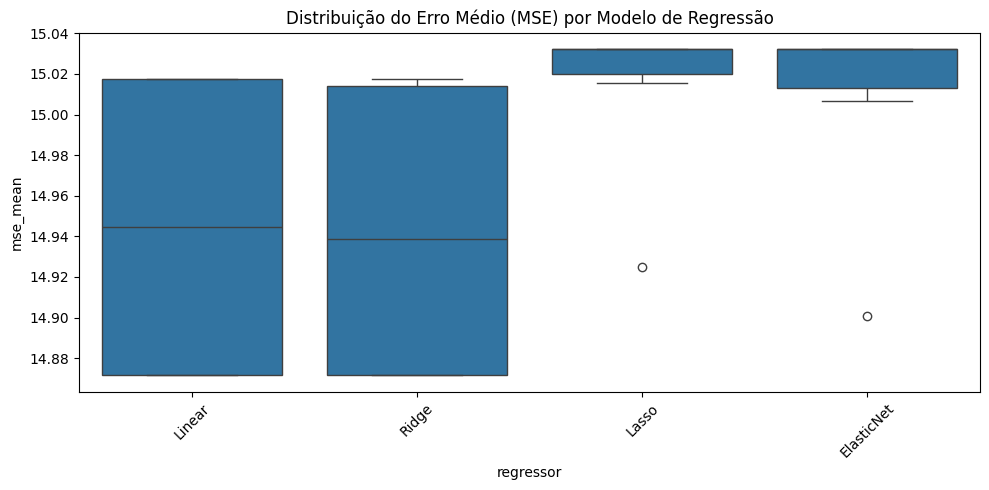

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='regressor', y='mse_mean', data=df_resultados)
plt.title('Distribuição do Erro Médio (MSE) por Modelo de Regressão')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

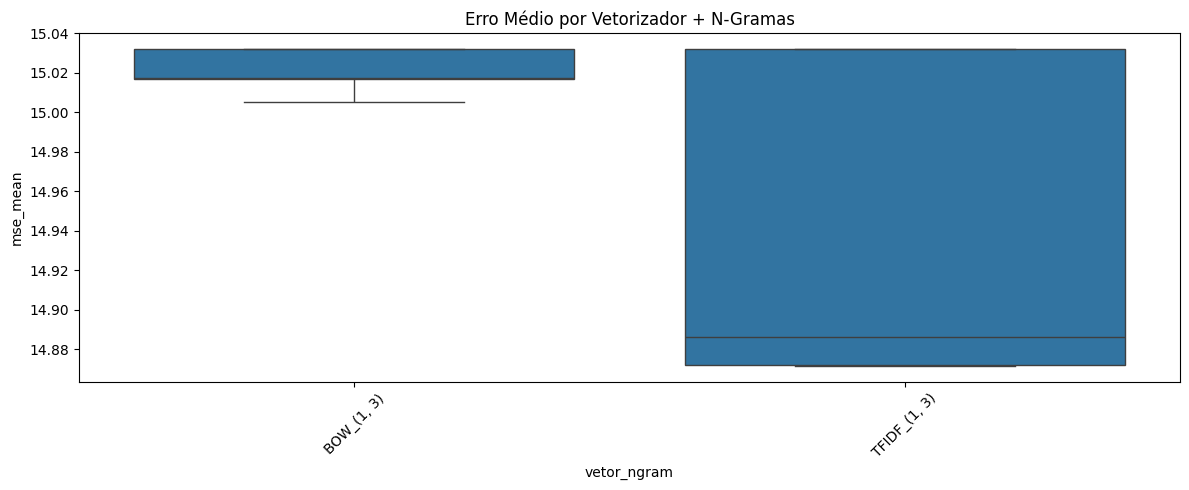

In [ ]:
df_resultados['vetor_ngram'] = df_resultados['vectorizer'] + '_' + df_resultados['ngram_range'].astype(str)

plt.figure(figsize=(12, 5))
sns.boxplot(x='vetor_ngram', y='mse_mean', data=df_resultados)
plt.title('Erro Médio por Vetorizador + N-Gramas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


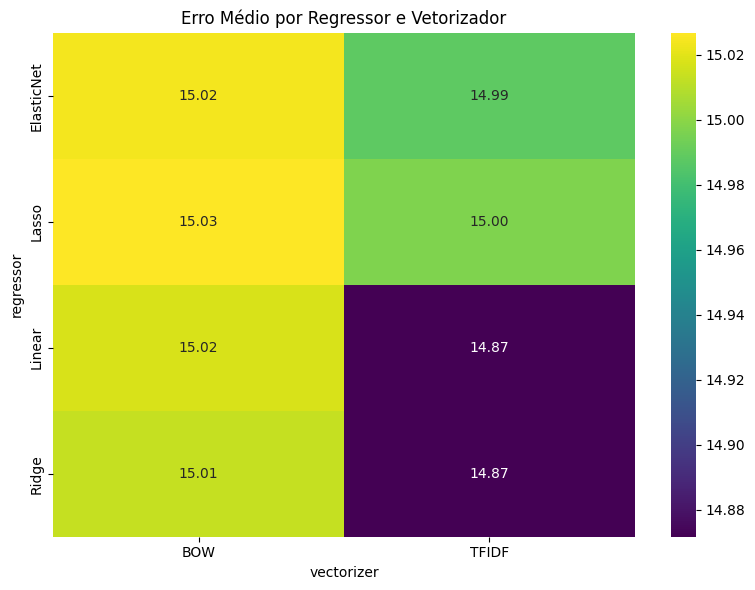

In [ ]:
pivot = df_resultados.pivot_table(
    values='mse_mean',
    index='regressor',
    columns='vectorizer',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis')
plt.title('Erro Médio por Regressor e Vetorizador')
plt.tight_layout()
plt.show()


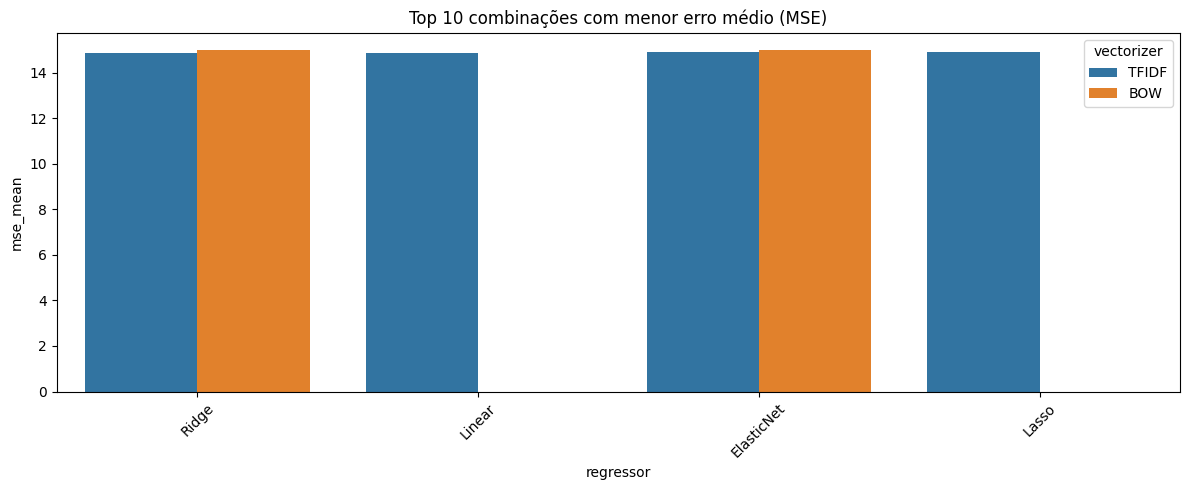

In [ ]:
top10 = df_resultados.sort_values(by='mse_mean').head(10)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=top10,
    x='regressor',
    y='mse_mean',
    hue='vectorizer'
)
plt.title('Top 10 combinações com menor erro médio (MSE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
